In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
heart_failure = pd.read_csv('heart.csv')
heart_failure.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
heart_failure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
heart_failure.shape

(918, 12)

In [5]:
print("Number of duplicate records:", heart_failure.duplicated().sum())

Number of duplicate records: 0


In [6]:
def validate_data(df):
    print("Data Validation Report:")

    print("\nAge range:", df['Age'].min(), "to", df['Age'].max())

    print("\nUnique Sex values:", df['Sex'].unique())

    print("\nUnique ChestPainType values:", df['ChestPainType'].unique())

    print("\nRestingBP range:", df['RestingBP'].min(), "to", df['RestingBP'].max())

    print("\nCholesterol range:", df['Cholesterol'].min(), "to", df['Cholesterol'].max())

    print("\nUnique FastingBS values:", df['FastingBS'].unique())

    print("\nUnique RestingECG values:", df['RestingECG'].unique())

    print("\nMaxHR range:", df['MaxHR'].min(), "to", df['MaxHR'].max())

    print("\nUnique ExerciseAngina values:", df['ExerciseAngina'].unique())

    print("\nUnique ST_Slope values:", df['ST_Slope'].unique())

validate_data(heart_failure)

Data Validation Report:

Age range: 28 to 77

Unique Sex values: ['M' 'F']

Unique ChestPainType values: ['ATA' 'NAP' 'ASY' 'TA']

RestingBP range: 0 to 200

Cholesterol range: 0 to 603

Unique FastingBS values: [0 1]

Unique RestingECG values: ['Normal' 'ST' 'LVH']

MaxHR range: 60 to 202

Unique ExerciseAngina values: ['N' 'Y']

Unique ST_Slope values: ['Up' 'Flat' 'Down']


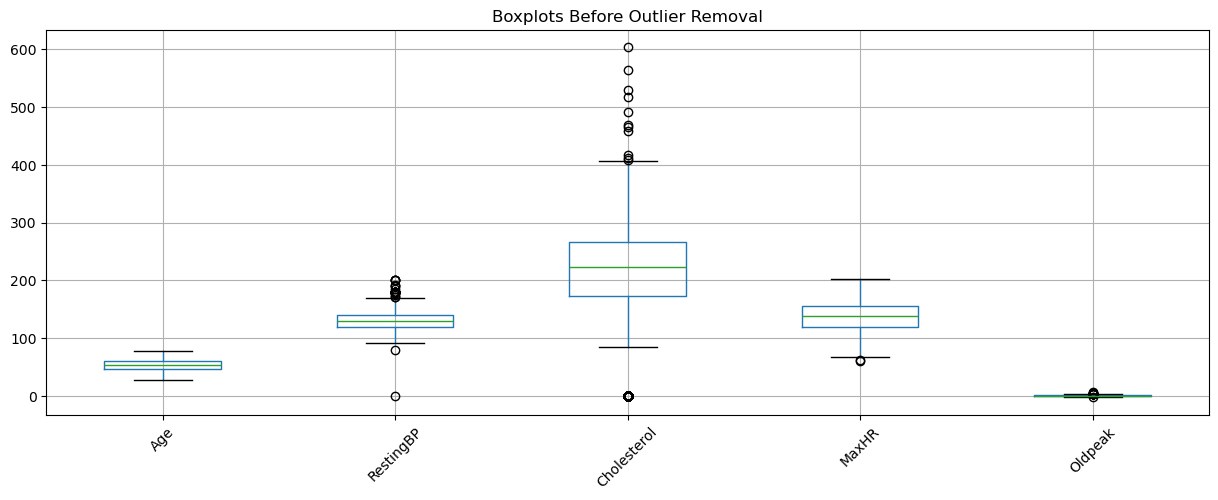


Number of outliers in Age: 0

Number of outliers in RestingBP: 28

Number of outliers in Cholesterol: 177

Number of outliers in MaxHR: 0

Number of outliers in Oldpeak: 12


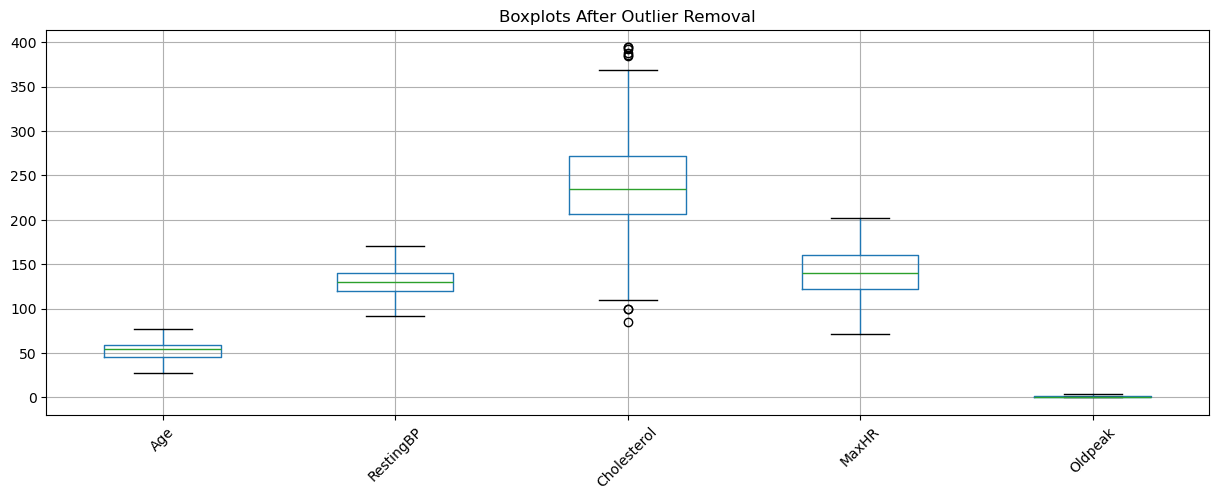


Original dataset size: 918
Dataset size after outlier removal: 701


In [7]:
def remove_outliers(df, columns):
    df_clean = df.copy()

    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((df_clean[column] < lower_bound) | (df_clean[column] > upper_bound))
        print(f"\nNumber of outliers in {column}: {outliers.sum()}")

        df_clean = df_clean[~outliers]

    return df_clean

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

plt.figure(figsize=(15, 5))
heart_failure[numerical_columns].boxplot()
plt.title('Boxplots Before Outlier Removal')
plt.xticks(rotation=45)
plt.show()

heart_failure_clean = remove_outliers(heart_failure, numerical_columns)

plt.figure(figsize=(15, 5))
heart_failure_clean[numerical_columns].boxplot()
plt.title('Boxplots After Outlier Removal')
plt.xticks(rotation=45)
plt.show()

print(f"\nOriginal dataset size: {len(heart_failure)}")
print(f"Dataset size after outlier removal: {len(heart_failure_clean)}")

Number of Cholesterol outliers: 29
Range for Cholesterol: 130.00 to 375.50


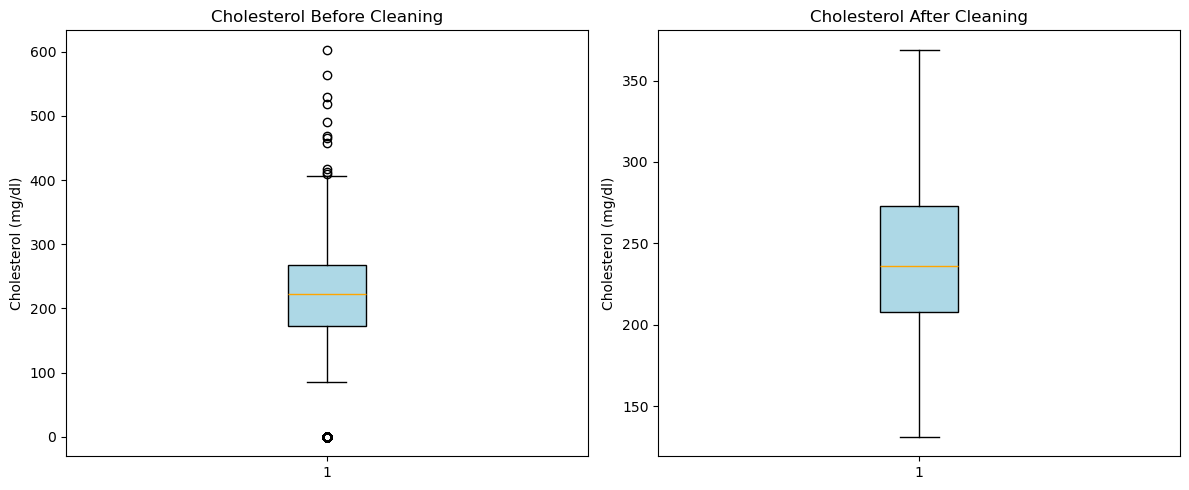


Cholesterol Statistics After Cleaning:
count    716.000000
mean     240.912011
std       46.498416
min      131.000000
25%      208.000000
50%      236.000000
75%      273.000000
max      369.000000
Name: Cholesterol, dtype: float64

Original dataset size: 918
Dataset size after cleaning: 716


In [8]:
def clean_cholesterol_improved(df):
    df_clean = df.copy()

    df_clean = df_clean[df_clean['Cholesterol'] >= 100]

    Q1 = df_clean['Cholesterol'].quantile(0.25)
    Q3 = df_clean['Cholesterol'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = max(Q1 - 1.5 * IQR, 130)
    upper_bound = min(Q3 + 1.5 * IQR, 400)

    cholesterol_outliers = ((df_clean['Cholesterol'] < lower_bound) |
                           (df_clean['Cholesterol'] > upper_bound))

    print(f"Number of Cholesterol outliers: {cholesterol_outliers.sum()}")
    print(f"Range for Cholesterol: {lower_bound:.2f} to {upper_bound:.2f}")

    df_clean = df_clean[~cholesterol_outliers]
    return df_clean

heart_failure_clean = clean_cholesterol_improved(heart_failure)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bp1 = plt.boxplot(heart_failure['Cholesterol'],
                 patch_artist=True,
                 medianprops=dict(color="orange"),
                 boxprops=dict(facecolor='lightblue'))
plt.title('Cholesterol Before Cleaning')
plt.ylabel('Cholesterol (mg/dl)')

plt.subplot(1, 2, 2)
bp2 = plt.boxplot(heart_failure_clean['Cholesterol'],
                 patch_artist=True,
                 medianprops=dict(color="orange"),
                 boxprops=dict(facecolor='lightblue'))
plt.title('Cholesterol After Cleaning')
plt.ylabel('Cholesterol (mg/dl)')

plt.tight_layout()
plt.show()

print("\nCholesterol Statistics After Cleaning:")
print(heart_failure_clean['Cholesterol'].describe())
print(f"\nOriginal dataset size: {len(heart_failure)}")
print(f"Dataset size after cleaning: {len(heart_failure_clean)}")

In [9]:
df = heart_failure_clean.copy()

le = LabelEncoder()

categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for column in categorical_columns:
    df[column] = le.fit_transform(df[column])

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]

stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5,
    stack_method='predict_proba'
)

stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              gro...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lr', LogisticRegression(random_state=42))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [11]:
minimal_risk = {
    'Age': 30,
    'Sex': 'F',
    'ChestPainType': 'TA',
    'RestingBP': 110,
    'Cholesterol': 150,
    'FastingBS': 0,
    'RestingECG': 'Normal',
    'MaxHR': 180,
    'ExerciseAngina': 'N',
    'Oldpeak': 0.0,
    'ST_Slope': 'Up'
}

borderline_case = {
    'Age': 55,
    'Sex': 'M',
    'ChestPainType': 'NAP',
    'RestingBP': 145,
    'Cholesterol': 250,
    'FastingBS': 1,
    'RestingECG': 'ST',
    'MaxHR': 155,
    'ExerciseAngina': 'N',
    'Oldpeak': 1.5,
    'ST_Slope': 'Flat'
}

maximum_risk = {
    'Age': 75,
    'Sex': 'M',
    'ChestPainType': 'ASY',
    'RestingBP': 180,
    'Cholesterol': 380,
    'FastingBS': 1,
    'RestingECG': 'ST',
    'MaxHR': 140,
    'ExerciseAngina': 'Y',
    'Oldpeak': 4.0,
    'ST_Slope': 'Down'
}



In [12]:
def get_detailed_risk_assessment(patient_data, probability):
    risk_prob = probability * 100

    # Detailed risk level assessment
    if risk_prob < 20:
        risk_level = "Low"
        recommendation = "Maintain healthy lifestyle and regular check-ups"
        timeframe = "Annual check-up recommended"
    elif risk_prob < 40:
        risk_level = "Moderate-Low"
        recommendation = "Continue regular monitoring with lifestyle modifications"
        timeframe = "Follow-up in 6 months"
    elif risk_prob < 60:
        risk_level = "Moderate-High"
        recommendation = "Schedule consultation with healthcare provider"
        timeframe = "Follow-up within 1 month"
    elif risk_prob < 80:
        risk_level = "High"
        recommendation = "Prompt medical evaluation needed"
        timeframe = "Follow-up within 1 week"
    else:
        risk_level = "Very High"
        recommendation = "Urgent medical attention required"
        timeframe = "Immediate medical attention"

    # Risk factor analysis
    risk_factors = []
    concerns = []

    # Age risk
    if patient_data['Age'] > 60:
        risk_factors.append("Advanced age")
    elif patient_data['Age'] > 45:
        concerns.append("Age-related risk")

    # Blood pressure analysis
    if patient_data['RestingBP'] >= 140:
        risk_factors.append("High blood pressure")
    elif patient_data['RestingBP'] >= 120:
        concerns.append("Elevated blood pressure")

    # Cholesterol analysis
    if patient_data['Cholesterol'] >= 240:
        risk_factors.append("High cholesterol")
    elif patient_data['Cholesterol'] >= 200:
        concerns.append("Borderline cholesterol")

    # ECG and other cardiac indicators
    if patient_data['ST_Slope'] == 'Down':
        risk_factors.append("Abnormal ST slope")
    elif patient_data['ST_Slope'] == 'Flat':
        concerns.append("Flat ST slope")

    if patient_data['ExerciseAngina'] == 'Y':
        risk_factors.append("Exercise-induced angina")

    if patient_data['ChestPainType'] == 'ASY':
        risk_factors.append("Asymptomatic chest pain")

    return risk_level, recommendation, timeframe, risk_factors, concerns

def predict_comprehensive(patient_data, model, scaler):
    # Prepare the data
    patient_df = pd.DataFrame([patient_data])

    # Encode categorical variables
    categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    le = LabelEncoder()
    for column in categorical_columns:
        patient_df[column] = le.fit_transform(patient_df[column])

    # Scale numerical features
    numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
    patient_df[numerical_columns] = scaler.transform(patient_df[numerical_columns])

    # Make prediction
    prediction = model.predict(patient_df)
    probability = model.predict_proba(patient_df)[0][1]

    # Get detailed risk assessment
    risk_level, recommendation, timeframe, risk_factors, concerns = get_detailed_risk_assessment(patient_data, probability)

    # Print comprehensive report
    print("\n=== Comprehensive Heart Disease Risk Assessment ===")
    print("\nPatient Profile:")
    print(f"Age: {patient_data['Age']}, Sex: {patient_data['Sex']}")
    print(f"Blood Pressure: {patient_data['RestingBP']} mm Hg")
    print(f"Cholesterol: {patient_data['Cholesterol']} mm/dl")
    print(f"Max Heart Rate: {patient_data['MaxHR']}")

    print("\nCritical Indicators:")
    print(f"Chest Pain Type: {patient_data['ChestPainType']}")
    print(f"Exercise Angina: {'Present' if patient_data['ExerciseAngina']=='Y' else 'Absent'}")
    print(f"ST Depression: {patient_data['Oldpeak']}")
    print(f"ST Slope: {patient_data['ST_Slope']}")

    print("\nRisk Assessment:")
    print(f"Risk Level: {risk_level}")
    print(f"Heart Disease Probability: {probability:.1%}")

    if risk_factors:
        print("\nMajor Risk Factors:")
        for factor in risk_factors:
            print(f"• {factor}")

    if concerns:
        print("\nAreas of Concern:")
        for concern in concerns:
            print(f"• {concern}")

    print(f"\nRecommendation: {recommendation}")
    print(f"Timeframe: {timeframe}")

    if risk_level in ["High", "Very High"]:
        print("\nWarning: Multiple high-risk factors detected. Immediate medical consultation advised.")

# Test with all three cases
print("MINIMAL RISK CASE:")
predict_comprehensive(minimal_risk, stacking, scaler)

print("\nBORDERLINE CASE:")
predict_comprehensive(borderline_case, stacking, scaler)

print("\nMAXIMUM RISK CASE:")
predict_comprehensive(maximum_risk, stacking, scaler)

MINIMAL RISK CASE:

=== Comprehensive Heart Disease Risk Assessment ===

Patient Profile:
Age: 30, Sex: F
Blood Pressure: 110 mm Hg
Cholesterol: 150 mm/dl
Max Heart Rate: 180

Critical Indicators:
Chest Pain Type: TA
Exercise Angina: Absent
ST Depression: 0.0
ST Slope: Up

Risk Assessment:
Risk Level: Moderate-Low
Heart Disease Probability: 37.2%

Recommendation: Continue regular monitoring with lifestyle modifications
Timeframe: Follow-up in 6 months

BORDERLINE CASE:

=== Comprehensive Heart Disease Risk Assessment ===

Patient Profile:
Age: 55, Sex: M
Blood Pressure: 145 mm Hg
Cholesterol: 250 mm/dl
Max Heart Rate: 155

Critical Indicators:
Chest Pain Type: NAP
Exercise Angina: Absent
ST Depression: 1.5
ST Slope: Flat

Risk Assessment:
Risk Level: High
Heart Disease Probability: 77.8%

Major Risk Factors:
• High blood pressure
• High cholesterol

Areas of Concern:
• Age-related risk
• Flat ST slope

Recommendation: Prompt medical evaluation needed
Timeframe: Follow-up within 1 week


In [13]:
y_pred_final = stacking.predict(X_test)
print("\nModel Performance Metrics:")
print(classification_report(y_test, y_pred_final))

cv_scores = cross_val_score(stacking, X, y, cv=5)
print(f"\nCross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Model Performance Metrics:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        75
           1       0.86      0.86      0.86        69

    accuracy                           0.86       144
   macro avg       0.86      0.86      0.86       144
weighted avg       0.86      0.86      0.86       144


Cross-validation accuracy: 0.849 (+/- 0.131)


In [14]:
import pickle

# Save the trained stacking model
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking, f)

# Save the trained scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the LabelEncoders for each categorical column
label_encoders = {}
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for column in categorical_columns:
    le = LabelEncoder()
    le.fit(heart_failure_clean[column])  # Notice: fitting on original data
    label_encoders[column] = le

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("✅ Model, scaler, and encoders have been saved successfully!")


✅ Model, scaler, and encoders have been saved successfully!
